0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
5.783927528858185 0.19098620788400597


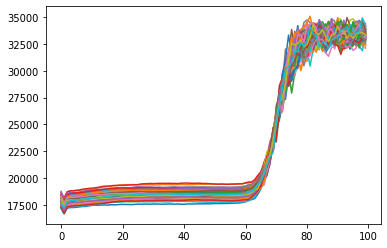

In [1]:
import numpy as np
import scipy
import argparse
import sys
import os
import time
import scipy.linalg
import scipy.stats
import matplotlib.pyplot as plt




def fOde(theta, x, k):
    """
    theta: list[2]: 
    """
    global Tt
    logX = x[:, 0]
    logXdt = 1e5 * theta[:, 0] * np.exp(-logX) + 1e3 * theta[:, 1] * Tt[k] * np.exp(-logX) - 3.5
    return np.stack([logXdt], axis=1)


enkf_ls = np.zeros((100, 100, 2))
time_ls = np.zeros(100)
obs_per_day = 1
days = 100
for EachRep in range(100):
    print(EachRep)
    start_time = time.time()
    SEED = np.random.randint(1, 100000)
    np.random.seed(SEED)
    yobs = np.load('G:/HIV observations.npy')[EachRep][:, 0].reshape(-1, 1)
    Tt = np.load('G:/HIV observations.npy')[EachRep][:, 1]
    ydata = yobs.copy()
    tvecObs = np.arange(0, days, 1 / obs_per_day)
    tvecFull = np.arange(0, days, 1 / obs_per_day)
    yFull = ydata.copy()
    xInitExogenous = np.zeros_like(yFull)
    for j in range(ydata.shape[1]):
        xInitExogenous[:, j] = np.interp(tvecFull, tvecObs, ydata[:, j])

    noise = 0.1
    dim_x = 1
    dim_theta = 2
    prior_mean_x0 = np.array([yFull[0, 0]])
    prior_variance_x0 = np.diag([noise ** 2])
    prior_mean_theta = np.array([0.18, -0.05])
    prior_variance_theta = np.diag([1, 1])
    var_obs_error = np.diag([noise ** 2])
    outlier_threshold = 0.03

    theta_roaming_variance_unit_time = np.diag([0.001, 0.001])

    simulation_size = 100000
    samples_x = np.zeros(shape=[yFull.shape[0], simulation_size, dim_x])
    samples_theta = np.zeros(shape=[yFull.shape[0], simulation_size, dim_theta])

    init_samples_x = np.random.multivariate_normal(prior_mean_x0, prior_variance_x0, simulation_size)
    init_samples_theta = np.random.multivariate_normal(prior_mean_theta, prior_variance_theta, simulation_size)

    samples_x[0] = init_samples_x
    samples_theta[0] = init_samples_theta

    for k in range(1, yFull.shape[0]):
        delta_t = tvecFull[k] - tvecFull[k-1]

        samples_pred_theta = samples_theta[k-1] + np.random.multivariate_normal(np.zeros(dim_theta), theta_roaming_variance_unit_time * delta_t, simulation_size)
        samples_pred_theta = np.asarray(scipy.stats.mstats.winsorize(samples_pred_theta, outlier_threshold))

        samples_pred_x = samples_x[k-1] + delta_t * fOde(samples_pred_theta, samples_x[k-1], k)
        samples_pred_x = np.asarray(scipy.stats.mstats.winsorize(samples_pred_x, outlier_threshold))

        if not np.any(np.isfinite(yFull[k, :])):
            samples_x[k] = samples_pred_x
            samples_theta[k] = samples_pred_theta
        else:
            yobs = yFull[k, :]

            # stochastic updates
            samples_obs_error = np.random.normal(0, noise, samples_pred_x.shape)
            samples_pred_y = samples_pred_x + samples_obs_error

            var_pred_y = np.cov(samples_pred_x.transpose()) + var_obs_error
            samples_pred_xtheta = np.hstack([samples_pred_x, samples_pred_theta])
            cov_pred_xtheta_y = np.cov(samples_pred_xtheta.transpose())[:, :dim_x]

            idx_yobs = np.isfinite(yobs)
            yobs = yobs[idx_yobs]
            var_pred_y = var_pred_y[idx_yobs, :][:, idx_yobs]
            cov_pred_xtheta_y = cov_pred_xtheta_y[:, idx_yobs]
            samples_pred_y = samples_pred_y[:, idx_yobs]

            invvar_pred_y = np.linalg.inv(var_pred_y)

            samples_pred_xtheta = samples_pred_xtheta + (cov_pred_xtheta_y @ invvar_pred_y @ (yobs.reshape([1,-1]) - samples_pred_y).transpose()).transpose()

            samples_x[k] = samples_pred_xtheta[:, :dim_x]
            samples_theta[k] = samples_pred_xtheta[:, dim_x:]
    enkf_ls[EachRep] = np.mean(samples_theta, axis=1)
    time_ls[EachRep] = time.time() - start_time

print(np.mean(time_ls), np.std(time_ls))


for i in range(100):
    plt.plot(1e5 * enkf_ls[i, :, 0] + 1e3 * enkf_ls[i, :, 1])

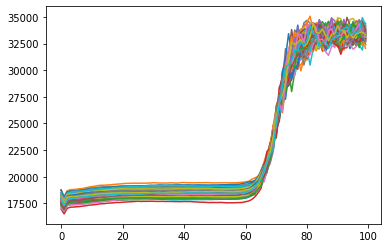

In [5]:
for i in range(100):
    plt.plot(1e5 * enkf_ls[i, :, 0] + 1e3 * enkf_ls[i, :, 1])

In [2]:
all_a1 = enkf_ls[:, :, 0]
all_a2 = enkf_ls[:, :, 1]

days = 100  
obs_per_day = 1
nobs = days * obs_per_day
linspace = 1000
X = np.arange(0, days, 1./(obs_per_day * linspace))
true_lambda = 36.
true_rho = 0.108 
k = 5e-4
true_gamma = np.cos(3.14 * X / 500)
true_delta = 0.1
N = 1000.
c = 3.5




def true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day, state0=[350., 20., 1200.],N=N, k=k, c=c, linspace=1000, noise=True):
    """
    generate data using pre-set parameters 
    """
    # check input
    # [ S, E, I, D, cfr0]
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 3))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (true_lambda - true_rho * state_ls[i - 1][0] - k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (k * (1-true_gamma[index]) * state_ls[i - 1][0] * state_ls[i - 1][2] - true_delta * state_ls[i - 1][1])
        state_ls[i][2] = state_ls[i - 1][2] + step_size * (N * true_delta * state_ls[i - 1][1] - c * state_ls[i - 1][2]) 
    states = state_ls[::obs_per_day * linspace]

    return states[:, 0], state_ls[:, 1], np.log(states[:, 2])


Tt, It, true_x = true_data(true_lambda, true_rho, true_gamma, true_delta, days, obs_per_day)
all_a = np.zeros((100, 100))
for i in range(100):
    all_a[i] = all_a1[i] * 1e5 + all_a2[i] * 1e3 * Tt
It_diff = np.zeros(100)
for i in range(100):
    It_diff[i] = (It[1000 * i + 1] - It[1000 * i]) * 1000
    
true_a = -N * It_diff + Tt * (N * k * (1-true_gamma[::1000]) * np.exp(true_x))


def recover_data(a1, a2, Tt, state0, linspace=100, days=100, obs_per_day=1, discretization=1, mode = 'Linear', hyper=None):
    """
    params: parameter: [re, pe, pi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    step_size = 1. / linspace
    state_ls = np.ones(days * linspace)
    state_ls[0] = state0
    x_initial = np.linspace(0, 1000, days)
    x_interp = np.linspace(0, 1000, days * linspace)
    Tt_interp = np.interp(x_interp, x_initial, Tt)
    if mode == 'Linear': 
        a1_interp = np.interp(x_interp, x_initial, a1)
        a2_interp = np.interp(x_interp, x_initial, a2)
        Tt_interp = np.interp(x_interp, x_initial, Tt)
       
    for i in range(1, linspace * days):
        index = i - 1
        state_ls[i] = state_ls[i - 1] + step_size * (
                    1e5 * a1_interp[index] * np.exp(-state_ls[i - 1]) + 1e3 * a2_interp[index] * Tt_interp[index] * np.exp(
                -state_ls[i - 1]) - 3.5)

    return state_ls[::linspace]

all_reconstructed_x = np.zeros((100, 100))
for i in range(100):
    print(i)
    all_reconstructed_x[i] = recover_data(all_a1[i], all_a2[i], Tt, np.log(1200))
    
all_reconstructed_x = all_reconstructed_x[~np.isnan(all_reconstructed_x).any(axis=1), :]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Text(0.5, 1.2, 'Results of EnKF across 100 simulations')

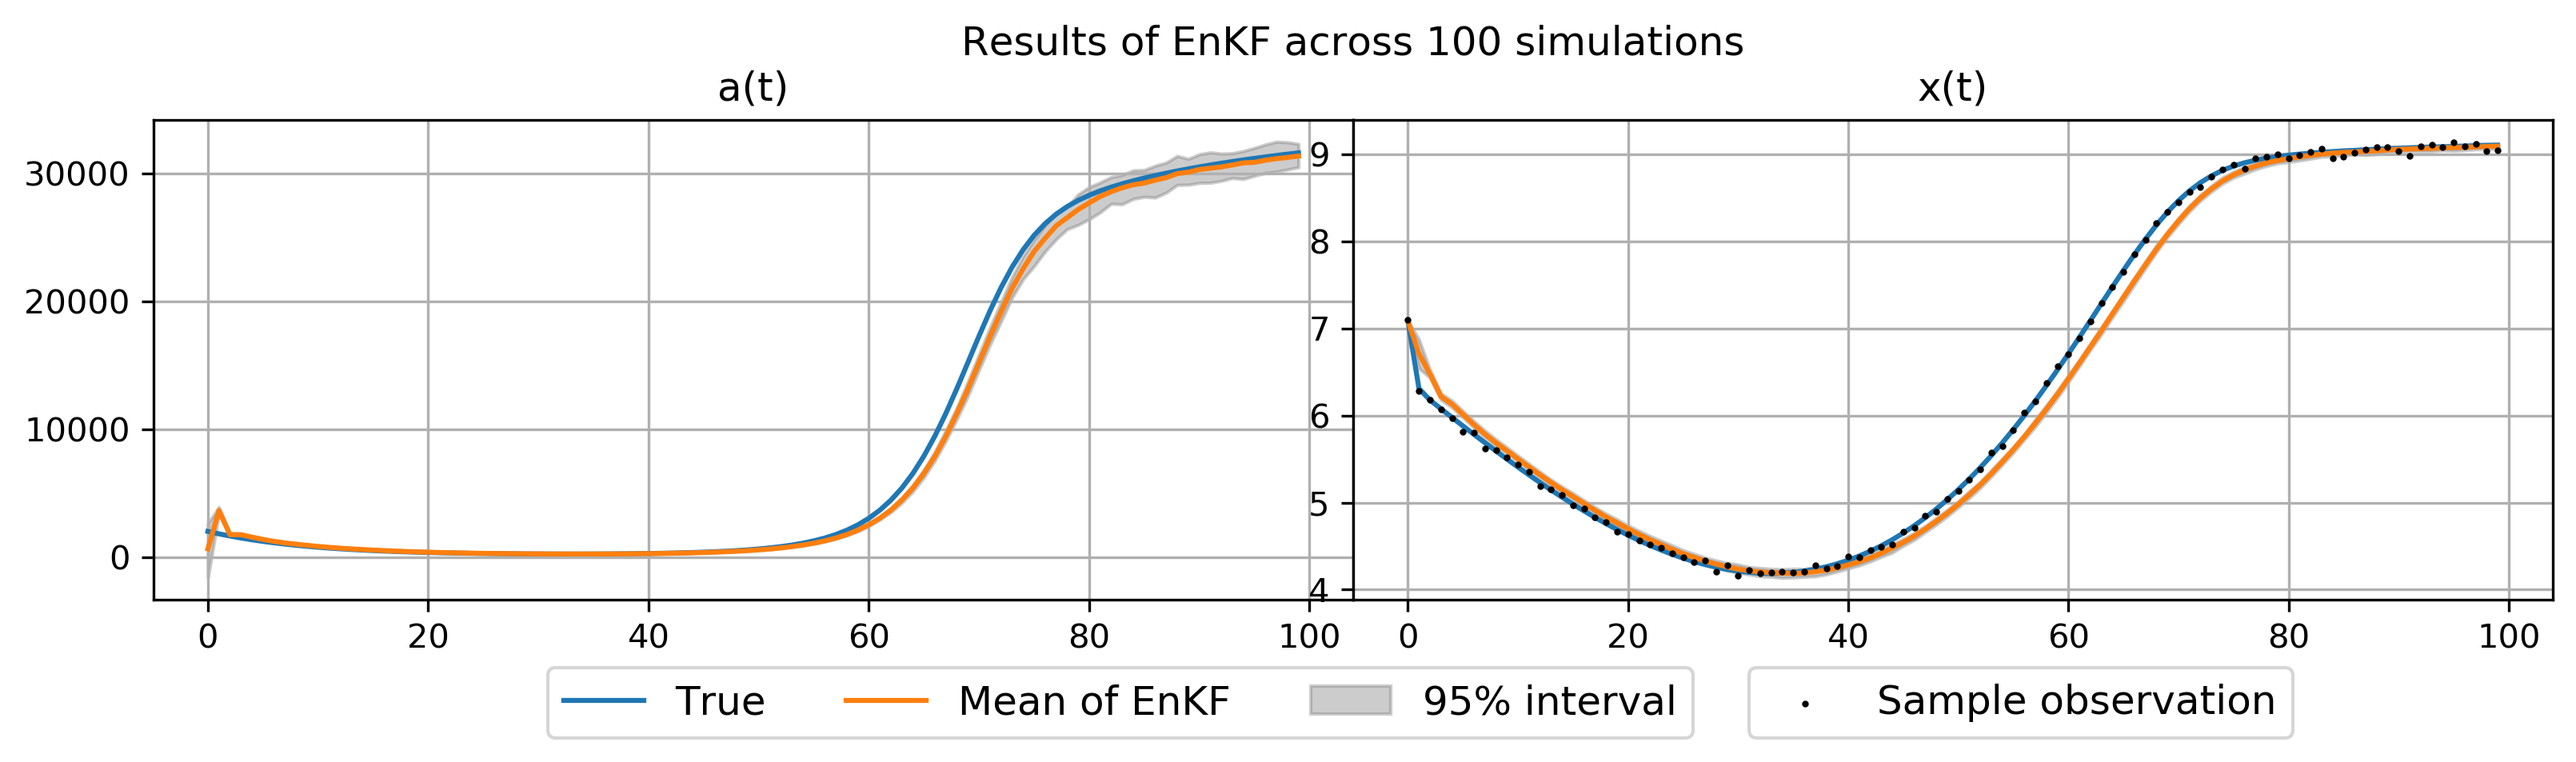

In [3]:
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
ax1 = plt.subplot(1, 2, 1)
lower_95 = np.percentile(all_a, 97.5, axis=0)
upper_95 = np.percentile(all_a, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(np.arange(0, days, 1 / obs_per_day), true_a, label='True')
plt.plot(x, np.mean(all_a, axis=0), label='Mean of EnKF')
plt.grid()
plt.title('a(t)')
plt.legend(bbox_to_anchor=(1.3, -0.1), fontsize=12, ncol=4)


ax1 = plt.subplot(1, 2, 2)
yobs = np.load('G:/HIV observations.npy')[1]
lower_95 = np.percentile(all_reconstructed_x, 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, days, 1 / obs_per_day), true_x)
plt.plot(x, np.mean(all_reconstructed_x, axis=0))
plt.scatter(np.arange(0, days, 1 / obs_per_day), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('x(t)')
plt.legend(bbox_to_anchor=(0.8, -0.1), fontsize=12, ncol=4)
plt.suptitle(r'Results of EnKF across 100 simulations', y=1.2)

In [8]:
a_RMSE = np.zeros(100)
x_RMSE = np.zeros(100)
for i in range(all_reconstructed_x.shape[0]):
    x_RMSE[i] = np.sqrt(np.mean(np.square(true_x - all_reconstructed_x[i])))
    a_RMSE[i] = np.sqrt(np.mean(np.square(true_a - all_a[i])))

print(np.mean(a_RMSE), np.std(a_RMSE))    
print(np.mean(x_RMSE), np.std(x_RMSE))

772.1585076454295 49.160440202337234
0.14856105058289595 0.0040062883572048414
